In [ ]:
# !pip install --upgrade --quiet pip
# !pip install --quiet torch==1.6.0 --index-url https://repo.usaa.com/artifactory/api/pypi/usaa-pypi-eval/simple --trusted-host repo.usaa.com
# !pip install --quiet /mnt/dgl_cu102-0.6.0-cp36-cp36m-manylinux1_x86_64.whl
# !pip install --upgrade --quiet tqdm
# !pip install --quiet tqdm==4.33.0 
# !pip install --quiet scikit-learn==0.24.2

In [1]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import dgl.function as Fn
from functools import partial
import seaborn as sns
import pickle
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
# import tsne_func
print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))
print("sklean version is {}".format(sklearn.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.6.0
sklean version is 0.24.2


In [2]:
def seed_everything(seed):
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [3]:
KG_dir="/home/ubuntu/"

if os.path.isfile("/home/ubuntu/CAP_Graph_07082021")==False:
    !hdfs dfs -get /dz/dz_6104/disc.db/CAP_Graph_07082021  ~/CAP_Graph_07082021

start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph_07082021'), 'rb') as f:
    G,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label= pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 8.8891 seconds to load graph


In [4]:
utils.graph_show(G)

**************************************************
Node_types:  ['usaanr']
Edge_types:  ['AUTO_RELATED', 'Brother_Sister', 'Busi_rel_Other', 'Child', 'Ex-Spouse', 'Parent', 'Pers_rel_Other', 'SPONSEE', 'SPONSOR', 'Spouse', 'Step-Child', 'Step-Parent']
**************************************************
Canonical Etypes of Graph is:

usaanr              AUTO_RELATED        usaanr              
usaanr              Brother_Sister      usaanr              
usaanr              Busi_rel_Other      usaanr              
usaanr              Child               usaanr              
usaanr              Ex-Spouse           usaanr              
usaanr              Parent              usaanr              
usaanr              Pers_rel_Other      usaanr              
usaanr              SPONSEE             usaanr              
usaanr              SPONSOR             usaanr              
usaanr              Spouse              usaanr              
usaanr              Step-Child          usaanr          

In [5]:
feat_list=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    feat_list.append(key)
feat_list=[x for x in feat_list if x not in ['ZIPCD','AGE','enl1stsdt','COMMSDT','PERSST','DEATHSDT']]

print()
print("The features associated with USAA Member are\n ")
for i in feat_list:
    print(i)


The features associated with USAA Member are
 
usaayr
AGE_BAND
ORIGEL
ELIG2
cmpyelig
SEX
MARST
BRANCH
MILST
MLIST_OrigStat
ENLPAYGD
ACTCORP
STATE
Segment


In [6]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,G,feature_size, feat_list):
        super(USAANR_Embedding,self).__init__()
        self.G=G.to(device)
        self.feature_size=feature_size
        self.feat_list=feat_list
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(self.feat_list):
            self.emb[col]=nn.Embedding(G.nodes['usaanr'].data[col].max().item()+1, feature_size)
    
    def forward(self,nid):
        nid=nid.to(device)
        extra_repr=[]
        
        for i,col in enumerate(self.feat_list):
            ndata=self.G.nodes['usaanr'].data[col]
            extra_repr.append(self.emb[col](ndata[nid]).squeeze(1))
        return th.stack(extra_repr, 0).sum(0)


In [7]:
class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 num_bases,
                 *,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.conv = dglnn.HeteroGraphConv({
                rel : dglnn.GraphConv(in_feat, out_feat, norm="both", weight=False, bias=False)
                for rel in rel_names
            })
        self.use_weight = weight
        self.use_basis = num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = dglnn.WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)
        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))
        self.dropout = nn.Dropout(dropout)
    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}
        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs
        hs = self.conv(g, inputs, mod_kwargs=wdict)
        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

In [8]:
class Entity_Classify(nn.Module):
    def __init__(self,
                 g,
                 feat_list,
                 h_dim,
                 out_dim,
                 num_bases,
#                  embed_layer,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False):
        super(Entity_Classify, self).__init__()
        self.g = g
        self.feat_list=feat_list
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
#         self.num_bases = None if num_bases < 0 else num_bases
        if num_bases < 0 or num_bases > len(self.rel_names):
            self.num_bases = len(self.rel_names)
        else:
            self.num_bases = num_bases
            
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop
        
#         self.node_embed={}
        self.node_embed=nn.ModuleDict()
        self.node_embed['usaanr'] = USAANR_Embedding(self.g,self.h_dim,self.feat_list)
#         self.node_embed['zipcode'] = Zipcode_Embedding(self.g,self.h_dim)
        self.layers = nn.ModuleList()
        #i2h
        self.layers.append(RelGraphConvLayer(
                    self.h_dim, self.h_dim, self.rel_names,
                    self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                    dropout=self.dropout, weight=True))
        # h2h
        if self.num_hidden_layers>1:
            for i in range(0,self.num_hidden_layers-1):
                self.layers.append(RelGraphConvLayer(
                    self.h_dim, self.h_dim, self.rel_names,
                    self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                    dropout=self.dropout))
        # h2o
#         self.layers.append(RelGraphConvLayer(
#             self.h_dim, self.out_dim, self.rel_names, 
#             self.num_bases, activation=partial(F.softmax, dim=1),
#             self_loop=self.use_self_loop))
        self.classifier = nn.Linear(self.h_dim, self.out_dim)
    
    def forward(self, input_nodes, blocks=None):
        H={}
        for ntype, nid in input_nodes.items():
            nid = input_nodes[ntype]
            H[ntype] = self.node_embed[ntype](nid)
        if blocks is None:
            for layer in self.layers:
                H = layer(self.g, H)
        else:
            for layer, block in zip(self.layers, blocks):
                H = layer(block, H)
        output = self.classifier(H["usaanr"])
    
        return output, H["usaanr"]

In [9]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()),2)
    return gain

def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def eval_loop_func(model, loader, labels, device, loss_weight, num_classes):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses=[]
    for input_nodes_raw, seeds, blocks in tqdm(loader, position=0, leave=True):
        blocks = [blk.to(device) for blk in blocks]
        seeds = seeds.to(device)
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}

        lbl = labels[seeds].squeeze().to(device)
        
        with th.no_grad():
            logits,h = model(input_nodes,blocks)
            if loss_weight is None:
                loss = F.cross_entropy(logits.view(-1, num_classes), lbl.to(device))
            else:
                loss = F.cross_entropy(logits.view(-1, num_classes), lbl.to(device),weight=th.Tensor(loss_weight).to(device))        
            losses.append(loss.item())
        fin_targets.append(lbl.cpu().detach().numpy())
        fin_outputs.append(logits.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses

def evaluate(pred_test, y_test):
    
    ## convert logits into probability
    pred_test=th.nn.functional.softmax(th.from_numpy(pred_test),dim=1).numpy()
    
    acc = np.sum(pred_test.argmax(axis=1) == y_test.squeeze()) / y_test.shape[0]
    prec_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(y_test.squeeze(), pred_test.argmax(axis=1), average='macro')
    prec_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(y_test.squeeze(), pred_test.argmax(axis=1), average='micro')
    prec_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_test.squeeze(), pred_test.argmax(axis=1), average='weighted')
    
    macro_roc_auc_ovo=roc_auc_score(y_test,pred_test,multi_class="ovo",average="macro")
    weighted_roc_auc_ovo=roc_auc_score(y_test,pred_test,multi_class="ovo",average="weighted")

    macro_roc_auc_ovr=roc_auc_score(y_test,pred_test,multi_class="ovr",average="macro")
    weighted_roc_auc_ovr=roc_auc_score(y_test,pred_test,multi_class="ovr",average="weighted")
    
    
    _, count=np.unique(y_test,return_counts=True)
    weight=count/count.sum()
    
    y_test_binary=label_binarize(y_test, classes=np.unique(y_test).tolist())
    
    roc_auc = dict()
    pr_auc = dict()
    n_classes = y_test_binary.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binary[:, i],pred_test[:, i])
        roc_auc[i] = auc_score(fpr, tpr)
        
        prec,rec,_ = precision_recall_curve(y_test_binary[:, i], th.sigmoid(th.from_numpy(pred_test))[:,i].numpy())
        pr_auc[i]=auc_score(rec,prec)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_binary.ravel(), pred_test.ravel())
    roc_auc["micro"] = auc_score(fpr, tpr)
    roc_auc["macro"]=0
    roc_auc["weighted"]=0
    for i in range(n_classes):
        roc_auc["macro"]+=roc_auc[i]
        roc_auc["weighted"]+=roc_auc[i]*weight[i]
    roc_auc["macro"]/=n_classes
    
    prec,rec,_ = precision_recall_curve(y_test_binary.ravel(), th.sigmoid(th.from_numpy(pred_test)).numpy().ravel())
    pr_auc["micro"]=auc_score(rec,prec)

    pr_auc["macro"]=0
    pr_auc["weighted"]=0
    for i in range(n_classes):
        pr_auc["macro"]+=pr_auc[i]
        pr_auc["weighted"]+=pr_auc[i]*weight[i]
    pr_auc["macro"]/=n_classes

    metrics = {}
    metrics['acc'] = acc
    metrics['prec_macro'] = prec_macro
    metrics['recall_macro'] = recall_macro
    metrics['fscore_macro'] = fscore_macro

    metrics['prec_micro'] = prec_micro
    metrics['recall_micro'] = recall_micro
    metrics['fscore_micro'] = fscore_micro

    metrics['prec_weighted'] = prec_weighted
    metrics['recall_weighted'] = recall_weighted
    metrics['fscore_weighted'] = fscore_weighted
    
    metrics['auc_micro']=roc_auc["micro"]
    
    metrics['auc_macro_ovo']=macro_roc_auc_ovo
    metrics['auc_macro_ovr']=macro_roc_auc_ovr
    
    metrics['auc_weighted_ovo']=weighted_roc_auc_ovo
    metrics['auc_weighted_ovr']=weighted_roc_auc_ovr  
    
    metrics['pr_auc_micro']=pr_auc["micro"]
    metrics['pr_auc_macro']=pr_auc["macro"]
    metrics['pr_auc_weighted']=pr_auc["weighted"]

    return metrics, roc_auc, pr_auc


In [10]:
# def evaluate(model, loader, labels, category, device):
#     model.eval()
#     total_loss = 0
#     total_acc = 0
# #     total_precision=0
# #     total_recall=0
#     total_fscore_macro=0
#     total_fscore_micro=0
#     total_fscore_weighted=0
# #     total_auc=0
# #     total_pr_auc=0
    
#     count = 0
#     count_loss=0
    
#     y_pred=[]
#     y_true=[]
    
#     for input_nodes_raw, seeds_raw, blocks in tqdm(loader, position=0, leave=True):
#         blocks = [blk.to(device) for blk in blocks]
        
#         seeds=seeds_raw.to(device)
        
#         input_nodes={}
#         input_nodes[category]=input_nodes_raw
#         input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
#         lbl = labels[seeds].to(device)
#         logits,h = model(input_nodes,blocks)
#         loss = F.cross_entropy(logits, lbl.squeeze(1).to(device))
# #         loss = F.cross_entropy(logits, lbl.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))
#         acc = th.sum(logits.argmax(dim=1) == lbl.squeeze(1)).item() / logits.shape[0]
# #         precision, recall, fscore, support = score(lbl.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy())

#         precision_macro, recall_macro, fscore_macro, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='macro')
#         precision_micro, recall_micro, fscore_micro, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='micro')
#         precision_weighted, recall_weighted, fscore_weighted, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='weighted')
        
#         y_pred.extend(logits.argmax(dim=1).tolist())
#         y_true.extend(lbl.squeeze().tolist())
        
# #         tempt=lbl.detach().cpu().numpy()
# #         labels_train_one_hot=np.zeros(shape=(tempt.shape[0],8),dtype=np.float32)
# #         labels_train_one_hot[np.arange(tempt.shape[0]),np.array([ele.item() for ele in tempt])]=1
# #         auc = roc_auc_score(labels_train_one_hot.ravel(), th.sigmoid(logits).detach().cpu().numpy().ravel())
        
# #         auc = roc_auc_score(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
# #         prec,rec,_ = precision_recall_curve(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
# #         pr_auc=auc_score(rec,prec)
        
#         total_loss += loss.item() * len(seeds) 
#         total_acc += acc
# #         total_precision += precision[1]
# #         total_recall += recall[1]
#         total_fscore_macro += fscore_macro
#         total_fscore_micro += fscore_micro
#         total_fscore_weighted += fscore_weighted
# #         total_auc += auc
# #         total_pr_auc += pr_auc
#         count += 1
#         count_loss += len(seeds)
    
#     ACCURACY=total_acc / count
#     LOSS=total_loss / count_loss
# #     PRECISION=total_precision/count
# #     RECALL=total_recall/count
#     F1_SCORE_macro=total_fscore_macro/count
#     F1_SCORE_micro=total_fscore_micro/count
#     F1_SCORE_weighted=total_fscore_weighted/count
# #     AUC=total_auc/count
# #     PR_AUC=total_pr_auc/count
    
#     return ACCURACY, LOSS, F1_SCORE_macro, F1_SCORE_micro, F1_SCORE_weighted, y_pred, y_true

In [11]:
def inference(model, graph, input_features, batch_size):
    """Minibatch inference of final representation over all node types.
    ***NOTE***
    For node classification, the model is trained to predict on only one node type's
    label.  Therefore, only that type's final representation is meaningful.
    """
    with th.no_grad():
        for l, layer in enumerate(model.layers):
            
            output_features = {
                k: th.zeros(
                    graph.number_of_nodes(k),
                    args.h_dim )
                for k in graph.ntypes}
            sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
            dataloader = dgl.dataloading.NodeDataLoader(
                graph,
                {k: th.arange(graph.number_of_nodes(k)) for k in graph.ntypes},
                sampler,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
                num_workers=0)
            
#             dataloader=[next(iter(dataloader)) for idx in range(10)]
            for input_nodes, output_nodes, blocks in tqdm(dataloader, position=0, leave=True):
                block = blocks[0].to(device)
                h = {k: input_features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
                h = layer(block, h)
                for k in h.keys():
#                     h[k]=th.matmul(h[k],model.classifier.weight.t())+model.classifier.bias
                    output_features[k][output_nodes[k]] = h[k].cpu()
            input_features = output_features
        
    return model.classifier(output_features["usaanr"])

In [12]:
# dict_edges={}
# for etype in G.etypes:
#     dict_edges[etype]=th.arange(G.num_edges(etype))[0:5000]
# G=dgl.edge_subgraph(G,dict_edges)

# G.nodes['usaanr'].data["_ID"].numpy().shape,node_labels.shape, node_labels[G.nodes['usaanr'].data["_ID"]].shape

#### settings

In [13]:
parser = argparse.ArgumentParser(description='RGCN')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=1,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-5,
        help="learning rate")
parser.add_argument("--num_bases", type=int, default=-1,
        help="number of filter weight matrices, default: -1 [use all]")
parser.add_argument("--num_layers", type=int, default=1,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--model_path", type=str, default="/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/rgcn_model_param.pt",
        help='path for save the model')
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")
parser.add_argument("--use_self_loop", default=True, action='store_true',
        help="include self feature as a special relation")
parser.add_argument("--batch-size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--fanout", type=int, default=None,
        help="Fan-out of neighbor sampling.")
parser.add_argument("--validation",  default=True,
        help="set up validation .")
parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")

parser.add_argument("--loss_weight",  type=bool,default=True,  ## number of label=0/number of label=1
        help="weight for unbalance data")
parser.add_argument("--num_worker",  type=int,default=0,  
        help="number of worker for neighbor sampling") 
    
args,unknown=parser.parse_known_args()

In [14]:
args.num_layers=1
args.dropout=0.2
args.lr=1e-3
args.l2norm=1e-3
args.n_epochs=1
args.num_bases=5
args.h_dim=64
args.batch_size=1024*10
print(args)

Namespace(batch_size=10240, dropout=0.2, fanout=None, gpu=0, h_dim=64, l2norm=0.001, loss_weight=True, lr=0.001, model_path='/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/rgcn_model_param.pt', n_epochs=1, num_bases=5, num_layers=1, num_mini_batch=8, num_worker=0, out_dim=1, seed=101, use_self_loop=True, validation=True)


#### Label

In [15]:
y=multi_label.squeeze().numpy()
n_classes=th.unique(multi_label).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
imbalance_classes["category"]=th.unique(multi_label).tolist()
imbalance_classes["product_type"]=["No Product","Rental Only","Home Only","Auto Only","Auto + Rental","Auto + Home"]
imbalance_classes["count"]=classes_count
imbalance_classes["percentage"]=classes_count/sum(classes_count)
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","percentage":"{:.2%}","weight":"{:.2f}"})

,category,product_type,count,percentage,weight
0,0,No Product,"18,891,343",73.60%,0.23
1,1,Rental Only,"239,092",0.93%,17.89
2,2,Home Only,"228,478",0.89%,18.72
3,3,Auto Only,"2,123,839",8.27%,2.01
4,4,Auto + Rental,"1,238,210",4.82%,3.46
5,5,Auto + Home,"2,947,542",11.48%,1.45


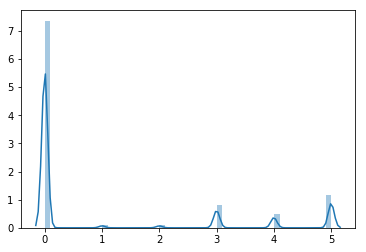

In [16]:
import seaborn as sns
sns.distplot(multi_label)

#### setting up training, validation and test set

In [17]:
train_idx=th.nonzero(train_mask_multi_label.squeeze()).numpy()
val_idx=th.nonzero(val_mask_multi_label.squeeze()).numpy()
test_idx=th.nonzero(test_mask_multi_label.squeeze()).numpy()

train_idx=th.from_numpy(train_idx).squeeze()    
val_idx=th.from_numpy(val_idx).squeeze()    
test_idx=th.from_numpy(test_idx).squeeze()

train_label=binary_label[train_idx].squeeze().numpy()
val_label=binary_label[val_idx].squeeze().numpy()
test_label=binary_label[test_idx].squeeze().numpy()

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,806
validation set  2,566,850 
test set        2,566,848 


In [18]:
##### check cuda
device="cpu"
use_cuda=args.gpu>=0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    device='cuda:%d' % args.gpu
print(device)

cuda:0


In [19]:
num_classes=th.unique(th.from_numpy(train_label)).shape[0]
if args.loss_weight:
    train_classes_num, train_classes_weight = get_class_count_weight(train_label,num_classes)
    loss_weight=th.tensor(train_classes_weight).to(device)
else:
    loss_weight=None

In [20]:
# create model
model = Entity_Classify(G,
                       feat_list,
                       args.h_dim,
                       n_classes,
                       num_bases=args.num_bases,
                       num_hidden_layers=args.num_layers,
                       dropout=args.dropout,
                       use_self_loop=args.use_self_loop)
if use_cuda:
    model.cuda()

model.layers

ModuleList(
  (0): RelGraphConvLayer(
    (conv): HeteroGraphConv(
      (mods): ModuleDict(
        (AUTO_RELATED): GraphConv(in=64, out=64, normalization=both, activation=None)
        (Brother_Sister): GraphConv(in=64, out=64, normalization=both, activation=None)
        (Busi_rel_Other): GraphConv(in=64, out=64, normalization=both, activation=None)
        (Child): GraphConv(in=64, out=64, normalization=both, activation=None)
        (Ex-Spouse): GraphConv(in=64, out=64, normalization=both, activation=None)
        (Parent): GraphConv(in=64, out=64, normalization=both, activation=None)
        (Pers_rel_Other): GraphConv(in=64, out=64, normalization=both, activation=None)
        (SPONSEE): GraphConv(in=64, out=64, normalization=both, activation=None)
        (SPONSOR): GraphConv(in=64, out=64, normalization=both, activation=None)
        (Spouse): GraphConv(in=64, out=64, normalization=both, activation=None)
        (Step-Child): GraphConv(in=64, out=64, normalization=both, activa

In [21]:
optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)

In [22]:
# train sampler
sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
train_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': train_idx}, sampler,
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
# validation sampler
# we do not use full neighbor to save computation resources
val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
val_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': val_idx}, val_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

test_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
test_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': test_idx}, test_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

print("The number of minibatch in training set is {:,}".format(len(train_loader)))
print("The number of minibatch in validation set is {:,}".format(len(val_loader)))
print("The number of minibatch in test set is {:,}".format(len(test_loader)))

The number of minibatch in training set is 2,006
The number of minibatch in validation set is 251
The number of minibatch in test set is 251


In [23]:
print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )

The total # of parameter is 43,010


In [24]:
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

node_embed.usaanr.emb.usaayr.weight                                   5,440          
node_embed.usaanr.emb.AGE_BAND.weight                                 448            
node_embed.usaanr.emb.ORIGEL.weight                                   2,752          
node_embed.usaanr.emb.ELIG2.weight                                    384            
node_embed.usaanr.emb.cmpyelig.weight                                 320            
node_embed.usaanr.emb.SEX.weight                                      320            
node_embed.usaanr.emb.MARST.weight                                    640            
node_embed.usaanr.emb.BRANCH.weight                                   1,088          
node_embed.usaanr.emb.MILST.weight                                    512            
node_embed.usaanr.emb.MLIST_OrigStat.weight                           192            
node_embed.usaanr.emb.ENLPAYGD.weight                                 1,600          
node_embed.usaanr.emb.ACTCORP.weight                  

In [25]:
# %pdb
LOSS_EPOCH=[]
LABEL_TRAIN=[]

# training loop
print("start training...")

total_loss=0
losses=[]

train_true=[]
train_pred=[]

# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True

for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (input_nodes_raw, seeds_raw, blocks) in enumerate(train_loader):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)
        
        labels_train=multi_label[seeds]       
        labels_train = labels_train.to(device)
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
        logits,h = model(input_nodes,blocks)
        optimizer.zero_grad()
        loss = F.cross_entropy(logits, labels_train.squeeze(1),weight=th.Tensor(weight).to(device))
#         loss = F.cross_entropy(logits, labels_train.squeeze(1).to(device))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        train_pred.extend(logits.argmax(dim=1).tolist())
        train_true.extend(labels_train.squeeze(1).tolist())

        train_acc = th.sum(logits.argmax(dim=1) == labels_train.squeeze(1)).item() / len(seeds)
        precision_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='macro')
        precision_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='micro')
        precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='weighted')

#         macro_roc_auc_ovo=roc_auc_score(labels_train,logits,multi_class="ovo",average="macro")
#         weighted_roc_auc_ovo=roc_auc_score(labels_train,logits,multi_class="ovo",average="weighted")
        
        
#         _, count=np.unique(labels_train,return_counts=True)
#         W=count/count.sum()

#         labels_train_binary=label_binarize(labels_train, classes=np.unique(labels_train).tolist())

#         roc_auc = dict()
#         pr_auc = dict()
#         n_classes = labels_train_binary.shape[1]
#         for i in range(n_classes):
#             fpr, tpr, _ = roc_curve(labels_train_binary[:, i],preds[:, i])
#             roc_auc[i] = auc_score(fpr, tpr)

#             prec,rec,_ = precision_recall_curve(labels_train_binary[:, i], th.sigmoid(th.from_numpy(logits))[:,i].numpy())
#             pr_auc[i]=auc_score(rec,prec)

#         # Compute micro-average ROC curve and ROC area
#         fpr, tpr, _ = roc_curve(labels_train_binary.ravel(), logits.ravel())
#         roc_auc["micro"] = auc_score(fpr, tpr)
#         roc_auc["macro"]=0
#         roc_auc["weighted"]=0
#         for i in range(n_classes):
#             roc_auc["macro"]+=roc_auc[i]
#             roc_auc["weighted"]+=roc_auc[i]*weight[i]
#         roc_auc["macro"]/=n_classes

#         prec,rec,_ = precision_recall_curve(labels_train_binary.ravel(), torch.sigmoid(torch.from_numpy(logits)).numpy().ravel())
#         pr_auc["micro"]=auc_score(rec,prec)

#         pr_auc["macro"]=0
#         pr_auc["weighted"]=0
#         for i in range(n_classes):
#             pr_auc["macro"]+=pr_auc[i]
#             pr_auc["weighted"]+=pr_auc[i]*weight[i]
#         pr_auc["macro"]/=n_classes


        IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        
        if step%(len(train_loader)//10)==0 and not step==0:

            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f}  | Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}".\
                  format(step,len(train_loader),np.mean(losses[-10:]),train_acc,fscore_macro,fscore_micro,fscore_weighted,elapsed))    
    
    LOSS_EPOCH.append(loss)

    LABEL_TRAIN.append(multi_label[blocks[-1].nodes["usaanr"].data[dgl.NID].cpu().numpy()])


    model.eval()
    print()
    print("")
    print("Running Validation on training set")
    print("")
    fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, train_loader, multi_label,  device, weight, n_classes)
    
    avg_loss_train=np.mean(losses_tmp)
    
    metrics_train, roc_auc_train, pr_auc_train = evaluate(fin_outputs, fin_targets)
    
    t2=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(weighted) {:.2%}  | roc-auc(macro) {:.2%}  | roc-auc(weighted) {:.2%}  | pr-auc(macro) {:.2%}  | pr-auc(weighted) {:.2%}  | Elapsed: {:}"\
      .format(avg_loss_train, metrics_train["acc"],  metrics_train['fscore_macro'], metrics_train['fscore_weighted'],  \
              metrics_train['auc_macro_ovo'], metrics_train['auc_weighted_ovo'],metrics_train['pr_auc_macro'], \
              metrics_train['pr_auc_weighted'],utils.format_time(t2-t1)))

    #====================================#
    #            Validation-set          #
    #====================================#
    
    model.eval()
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    
    fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, val_loader, multi_label, device, weight, n_classes)
    
    avg_loss_val=np.mean(losses_tmp)
    
    metrics_val, roc_auc_val, pr_auc_val = evaluate(fin_outputs, fin_targets)
    
    t3=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(weighted) {:.2%}  | roc-auc(macro) {:.2%}  | roc-auc(weighted) {:.2%}  | pr-auc(macro) {:.2%}  | pr-auc(weighted) {:.2%}  | Elapsed: {:}"\
          .format(avg_loss_val, metrics_val["acc"],  metrics_val['fscore_macro'], metrics_val['fscore_weighted'],  \
          metrics_val['auc_macro_ovo'], metrics_val['auc_weighted_ovo'],metrics_val['pr_auc_macro'], \
          metrics_val['pr_auc_weighted'],utils.format_time(t3-t2)))
    
# if args.model_path is not None:
#     th.save(model.state_dict(), args.model_path)
    
#====================================#
#            Test-set                #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, test_loader, multi_label,  device, weight, n_classes)
    
avg_loss_test=np.mean(losses_tmp)

metrics_test, roc_auc_test, pr_auc_test = evaluate(fin_outputs, fin_targets)

t4=time.time()

print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(weighted) {:.2%}  | roc-auc(macro) {:.2%}  | roc-auc(weighted) {:.2%}  | pr-auc(macro) {:.2%}  | pr-auc(weighted) {:.2%}  | Elapsed: {:}"\
  .format(avg_loss_test, metrics_test["acc"],  metrics_test['fscore_macro'], metrics_test['fscore_weighted'],  \
          metrics_test['auc_macro_ovo'], metrics_test['auc_weighted_ovo'],metrics_test['pr_auc_macro'], \
          metrics_test['pr_auc_weighted'],utils.format_time(t4-t3)))

  0%|          | 0/1 [00:00<?, ?it/s]

start training...

========= Epoch 1 /1
Training...
Batch 200 of 2006 | Loss 0.815  | Accuracy 85.59% | F1-Score(macro) 50.23%  | F1-Score(micro) 85.59% | F1-Score(weighted) 86.95% | Elapsed: 0:01:11
Batch 400 of 2006 | Loss 0.720  | Accuracy 86.49% | F1-Score(macro) 52.53%  | F1-Score(micro) 86.49% | F1-Score(weighted) 87.69% | Elapsed: 0:02:03
Batch 600 of 2006 | Loss 0.686  | Accuracy 87.79% | F1-Score(macro) 55.57%  | F1-Score(micro) 87.79% | F1-Score(weighted) 88.83% | Elapsed: 0:02:53
Batch 800 of 2006 | Loss 0.667  | Accuracy 87.70% | F1-Score(macro) 56.12%  | F1-Score(micro) 87.70% | F1-Score(weighted) 88.95% | Elapsed: 0:03:51
Batch 1000 of 2006 | Loss 0.659  | Accuracy 87.76% | F1-Score(macro) 56.46%  | F1-Score(micro) 87.76% | F1-Score(weighted) 88.78% | Elapsed: 0:04:40
Batch 1200 of 2006 | Loss 0.656  | Accuracy 87.82% | F1-Score(macro) 57.62%  | F1-Score(micro) 87.82% | F1-Score(weighted) 88.82% | Elapsed: 0:05:34
Batch 1400 of 2006 | Loss 0.645  | Accuracy 87.67% | F1-Sc

  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  1%|          | 2/251 [00:00<00:22, 11.21it/s]

loss: 0.626 |  Accuracy 88.23% | F1-Score(macro) 56.84%  | F1-Score(weighted) 89.30%  | roc-auc(macro) 94.06%  | roc-auc(weighted) 97.78%  | pr-auc(macro) 64.91%  | pr-auc(weighted) 93.03%  | Elapsed: 0:13:14


Running Validation on validation set



  1%|          | 2/251 [00:00<00:21, 11.44it/s]

loss: 0.609 |  Accuracy 88.21% | F1-Score(macro) 56.79%  | F1-Score(weighted) 89.28%  | roc-auc(macro) 94.03%  | roc-auc(weighted) 97.77%  | pr-auc(macro) 64.84%  | pr-auc(weighted) 93.02%  | Elapsed: 0:01:25


Running Validation in Test Dataset



100%|██████████| 251/251 [00:49<00:00,  5.09it/s]


loss: 0.608 |  Accuracy 88.22% | F1-Score(macro) 56.80%  | F1-Score(weighted) 89.29%  | roc-auc(macro) 94.05%  | roc-auc(weighted) 97.78%  | pr-auc(macro) 64.74%  | pr-auc(weighted) 93.01%  | Elapsed: 0:01:26


In [26]:
%%time
print()
print("********  model performance in training set **********  \n ")
print()
    
fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, train_loader, multi_label, device, weight, n_classes)
metrics_dict, roc_auc, pr_auc = evaluate(fin_outputs, fin_targets)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=th.unique(multi_label).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(fin_targets.squeeze(), fin_outputs.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                        metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                        metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})

  0%|          | 0/2006 [00:00<?, ?it/s]


********  model performance in training set **********  
 



100%|██████████| 2006/2006 [06:22<00:00,  5.25it/s]


accuracy            88.23%    

precision(macro):   58.25%    recall(macro):  72.39%    f1-score(macro):  56.84%    ROC-AUC(macro):  94.06%    PR-AUC(macro):  64.91%    
precision(micro):   88.23%    recall(micro):  88.23%    f1-score(micro):  88.23%    ROC-AUC(micro):  99.33%    PR-AUC(micro):  97.11%    
precision(weight):  92.09%    recall(weight): 88.23%    f1-score(weight): 89.30%    ROC-AUC(weight): 97.78%    PR-AUC(weight): 93.03%    

CPU times: user 12min 21s, sys: 1min 52s, total: 14min 13s
Wall time: 13min 58s


,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"15,113,075",100.00%,99.77%,99.89%,99.95%,99.99%
1,Rental Only,"191,274",23.38%,98.00%,37.76%,99.04%,43.81%
2,Home Only,"182,783",15.29%,82.25%,25.78%,97.90%,29.26%
3,Auto Only,"1,699,072",71.73%,44.49%,54.92%,97.11%,72.59%
4,Auto + Rental,"990,568",56.57%,47.13%,51.42%,96.16%,56.19%
5,Auto + Home,"2,358,034",82.50%,62.69%,71.25%,98.68%,87.62%
6,MACRO,"20,534,806",58.25%,72.39%,56.84%,94.06%,64.91%
7,MICRO,"20,534,806",88.23%,88.23%,88.23%,99.33%,97.11%
8,WEIGHT,"20,534,806",92.09%,88.23%,89.30%,97.78%,93.03%


In [27]:
%%time
print()
print("********  model performance in validation set **********  \n ")
print()
    
fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, val_loader, multi_label, device, weight, n_classes)
metrics_dict, roc_auc, pr_auc = evaluate(fin_outputs, fin_targets)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=th.unique(multi_label).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(fin_targets.squeeze(), fin_outputs.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                        metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                        metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})

  1%|          | 2/251 [00:00<00:22, 10.92it/s]


********  model performance in validation set **********  
 



100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


accuracy            88.21%    

precision(macro):   58.20%    recall(macro):  72.31%    f1-score(macro):  56.79%    ROC-AUC(macro):  94.03%    PR-AUC(macro):  64.84%    
precision(micro):   88.21%    recall(micro):  88.21%    f1-score(micro):  88.21%    ROC-AUC(micro):  99.33%    PR-AUC(micro):  97.10%    
precision(weight):  92.07%    recall(weight): 88.21%    f1-score(weight): 89.28%    ROC-AUC(weight): 97.77%    PR-AUC(weight): 93.02%    

CPU times: user 1min 23s, sys: 9.48 s, total: 1min 33s
Wall time: 1min 29s


,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"1,889,134",100.00%,99.77%,99.88%,99.95%,99.98%
1,Rental Only,"23,909",23.38%,98.01%,37.75%,99.03%,43.61%
2,Home Only,"22,848",15.19%,81.89%,25.63%,97.86%,29.16%
3,Auto Only,"212,384",71.48%,44.51%,54.86%,97.10%,72.48%
4,Auto + Rental,"123,821",56.73%,47.13%,51.49%,96.17%,56.21%
5,Auto + Home,"294,754",82.44%,62.53%,71.12%,98.68%,87.59%
6,MACRO,"2,566,850",58.20%,72.31%,56.79%,94.03%,64.84%
7,MICRO,"2,566,850",88.21%,88.21%,88.21%,99.33%,97.10%
8,WEIGHT,"2,566,850",92.07%,88.21%,89.28%,97.77%,93.02%


In [28]:
%%time
print()
print("********  model performance in test set **********  \n ")
print()
    
fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, test_loader, multi_label, device, weight, n_classes)
metrics_dict, roc_auc, pr_auc = evaluate(fin_outputs, fin_targets)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=th.unique(multi_label).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(fin_targets.squeeze(), fin_outputs.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                        metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                        metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})

  1%|          | 2/251 [00:00<00:22, 10.97it/s]


********  model performance in test set **********  
 



100%|██████████| 251/251 [00:21<00:00, 11.89it/s]


accuracy            88.22%    

precision(macro):   58.20%    recall(macro):  72.34%    f1-score(macro):  56.80%    ROC-AUC(macro):  94.05%    PR-AUC(macro):  64.74%    
precision(micro):   88.22%    recall(micro):  88.22%    f1-score(micro):  88.22%    ROC-AUC(micro):  99.33%    PR-AUC(micro):  97.10%    
precision(weight):  92.06%    recall(weight): 88.22%    f1-score(weight): 89.29%    ROC-AUC(weight): 97.78%    PR-AUC(weight): 93.01%    

CPU times: user 1min, sys: 4.31 s, total: 1min 5s
Wall time: 1min 2s


,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"1,889,134",100.00%,99.77%,99.89%,99.95%,99.99%
1,Rental Only,"23,909",23.46%,98.08%,37.86%,99.03%,43.28%
2,Home Only,"22,847",15.24%,82.07%,25.71%,97.88%,28.88%
3,Auto Only,"212,383",71.60%,44.62%,54.98%,97.11%,72.54%
4,Auto + Rental,"123,821",56.49%,46.85%,51.22%,96.17%,56.20%
5,Auto + Home,"294,754",82.41%,62.62%,71.16%,98.68%,87.53%
6,MACRO,"2,566,848",58.20%,72.34%,56.80%,94.05%,64.74%
7,MICRO,"2,566,848",88.22%,88.22%,88.22%,99.33%,97.10%
8,WEIGHT,"2,566,848",92.06%,88.22%,89.29%,97.78%,93.01%


#### Model Save

In [31]:
if not os.path.exists("/mnt/bgnn/model_save/"):
    os.makedirs("/mnt/bgnn/model_save/")
th.save(model.state_dict(),"/mnt/bgnn/model_save/Graph_Conv.pt")
!hdfs dfs -put -f /mnt/bgnn/model_save/Graph_Conv.pt  /dz/dz_6104/disc.db/BGNN/Graph_Conv.pt
os.system("rm /mnt/bgnn/model_save/Graph_Conv.pt")

0

#### Score Test Dataset

In [36]:
path="/home/ubuntu"
if not os.path.isfile(os.path.join(path,"Graph_Conv.pt")):
    !hdfs dfs -get  /dz/dz_6104/disc.db/BGNN/Graph_Conv.pt     /home/ubuntu


model = Entity_Classify(G,
                       feat_list,
                       args.h_dim,
                       n_classes,
                       num_bases=args.num_bases,
                       num_hidden_layers=args.num_layers,
                       dropout=args.dropout,
                       use_self_loop=args.use_self_loop)


model.cuda()
model.load_state_dict(th.load(os.path.join(path,"Graph_Conv.pt")))

In [37]:
IDX_test=[]
H_test=[]
LOGIT_test=[]
LABEL_test=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(test_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    seeds=seeds_raw.to(device)
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_test.append(seeds.detach().cpu().numpy().tolist())
    H_test.append(h.detach().cpu().numpy().tolist())
    LOGIT_test.append(logits.detach().cpu().numpy().tolist())
    LABEL_test.append(multi_label[blocks[-1].dstdata[dgl.NID].cpu().numpy()].tolist())

IDX_test=np.concatenate(IDX_test)
H_test=np.concatenate(H_test)
LOGIT_test=np.concatenate(LOGIT_test)
LABEL_test=np.concatenate(LABEL_test)

print("Logit Dimension is {:}".format(LOGIT_test.shape))
print("Label Dimension is {:}".format(LABEL_test.shape))

  0%|          | 0/251 [00:00<?, ?it/s]


DGLError: [08:53:25] /opt/dgl/src/array/cuda/array_op_impl.cu:91: Check failed: e == cudaSuccess || e == cudaErrorCudartUnloading: CUDA kernel launch error: out of memory
Stack trace:
  [bt] (0) /usr/local/anaconda/lib/python3.6/site-packages/dgl/libdgl.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x4f) [0x7f2d6eb5d10f]
  [bt] (1) /usr/local/anaconda/lib/python3.6/site-packages/dgl/libdgl.so(dgl::runtime::NDArray dgl::aten::impl::BinaryElewise<(DLDeviceType)2, long, dgl::aten::arith::LT>(dgl::runtime::NDArray, long)+0x174) [0x7f2d6f3c3954]
  [bt] (2) /usr/local/anaconda/lib/python3.6/site-packages/dgl/libdgl.so(dgl::aten::LT(dgl::runtime::NDArray, long)+0x207) [0x7f2d6eb68017]
  [bt] (3) /usr/local/anaconda/lib/python3.6/site-packages/dgl/libdgl.so(dgl::HeteroGraph::HasVertices(unsigned long, dgl::runtime::NDArray) const+0xbb) [0x7f2d6f2a7dbb]
  [bt] (4) /usr/local/anaconda/lib/python3.6/site-packages/dgl/libdgl.so(+0xca7159) [0x7f2d6f2b9159]
  [bt] (5) /usr/local/anaconda/lib/python3.6/site-packages/dgl/libdgl.so(DGLFuncCall+0x48) [0x7f2d6f249aa8]
  [bt] (6) /usr/local/anaconda/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f2e9e990ec0]
  [bt] (7) /usr/local/anaconda/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f2e9e99087d]
  [bt] (8) /usr/local/anaconda/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f2e9eba6ede]



In [ ]:
%%time
if not os.path.exists("/mnt/bgnn/model_save/"):
    os.makedirs("/mnt/bgnn/model_save/")
savez_compressed("/mnt/bgnn/model_save/Graph_Conv_LOGIT.npz", LOGIT_test)
savez_compressed("/mnt/bgnn/model_save/Graph_Conv_LABEL.npz", LABEL_test)
!hdfs dfs -put -f /mnt/bgnn/model_save/Graph_Conv_LOGIT.npz  /dz/dz_6104/disc.db/BGNN/Graph_Conv_LOGIT.npz
!hdfs dfs -put -f /mnt/bgnn/model_save/Graph_Conv_LABEL.npz  /dz/dz_6104/disc.db/BGNN/Graph_Conv_LABEL.npz
os.system("rm /mnt/bgnn/model_save/Graph_Conv_LOGIT.npz")
os.system("rm /mnt/bgnn/model_save/Graph_Conv_LABEL.npz")

In [ ]:
path="/home/ubuntu"
if not os.path.isfile(os.path.join(path,"Graph_Conv_LOGIT.npz")):
    !hdfs dfs -get  /dz/dz_6104/disc.db/BGNN/Graph_Conv_LOGIT.npz     /home/ubuntu
    !hdfs dfs -get  /dz/dz_6104/disc.db/BGNN/Graph_Conv_LABEL.npz     /home/ubuntu

fin_logits_graph = load("/home/ubuntu/Graph_Conv_LOGIT.npz")['arr_0']
fin_targets_graph = load("/home/ubuntu/Graph_Conv_LABEL.npz")['arr_0']

metrics_dict, roc_auc, pr_auc =evaluate(fin_logits_graph, fin_targets_graph.squeeze())
print("")
print("==> Running Validation on validation set \n")
print("")

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

#### sparsity rate of embedding vector

In [ ]:
H=np.array(H)
non_zero=np.count_nonzero(H)
total_val=np.product(H.shape)
sparsity=(total_val-non_zero)/total_val
density=non_zero/total_val
print("sparsity rate is {:.2%}".format(sparsity))
print("density rate is {:.2%}".format(density))
print("embedding vector shape is {}".format(H.shape))

In [ ]:
IDX_train=np.array(IDX)
H_train=np.array(H)
mask_train=np.array(['train']*len(IDX_train))

In [ ]:
IDX_val=[]
H_val=[]
LOGIT_val=[]
LABEL_val=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(val_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    seeds=seeds_raw.to(device)
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_val.append(seeds.detach().cpu().numpy().tolist())
    H_val.append(h.detach().cpu().numpy().tolist())
    LOGIT_val.append(logits.detach().cpu().numpy().tolist())
    LABEL_val.append(multi_label[blocks[-1].dstdata[dgl.NID].cpu().numpy()].tolist())

IDX_val=np.concatenate(IDX_val)
H_val=np.concatenate(H_val)
LOGIT_val=np.concatenate(LOGIT_val)
LABEL_val=np.concatenate(LABEL_val)
mask_val=np.array(['val']*len(IDX_val))

In [ ]:
IDX_test=[]
H_test=[]
LOGIT_test=[]
LABEL_test=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(test_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    seeds=seeds_raw.to(device)
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_test.append(seeds.detach().cpu().numpy().tolist())
    H_test.append(h.detach().cpu().numpy().tolist())
    LOGIT_test.append(logits.detach().cpu().numpy().tolist())
    LABEL_test.append(multi_label[blocks[-1].dstdata[dgl.NID].cpu().numpy()].tolist())

IDX_test=np.concatenate(IDX_test)
H_test=np.concatenate(H_test)
LOGIT_test=np.concatenate(LOGIT_test)
LABEL_test=np.concatenate(LABEL_test)
mask_test=np.array(['test']*len(IDX_test))

In [ ]:
IDX=np.concatenate((IDX_train,IDX_val, IDX_test))
H=np.concatenate((H_train,H_val, H_test))
mask=np.concatenate((mask_train,mask_val, mask_test))

_idx=IDX.argsort()  #### sort the node id from 0 to max_num, so that it can be matched with LABEL
embedding_vector=H[_idx]
mask=mask[_idx]

print("{:<30}{}".format("shape of embedding vector",embedding_vector.shape))

In [ ]:
# %%time
# savez_compressed("embedding_vector.npz",embedding_vector)
# embedding_vector=load("embedding_vector.npz")['arr_0']

In [ ]:
# %%time
# embedding_vector=load("embedding_vector.npz")['arr_0']

#### visualization of embedding vectors for different categories of USAA Members

In [ ]:
DF=pd.DataFrame({"IDX":_idx.tolist(), "MASK":mask.tolist(), "Product":multi_label.squeeze().tolist()})
prod_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",4:"Auto + Home"}
DF['Product'] = list(map(prod_map.get, DF['Product']))

N=1000

train_df=DF[DF["MASK"]=="train"]
sample_df_train=train_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_train=sample_df_train["IDX"].values
# prod_sample_train=DF['Product'].values[sample_id_train]
prod_sample_train=DF[DF["IDX"].isin(sample_id_train)]['Product'].values
embedding_sample_train=embedding_vector[DF["IDX"].isin(sample_id_train)]

val_df=DF[DF["MASK"]=="val"]
sample_df_val=val_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_val=sample_df_val["IDX"].values
# prod_sample_val=DF['Product'].values[sample_id_val]
prod_sample_val=DF[DF["IDX"].isin(sample_id_val)]['Product'].values
embedding_sample_val=embedding_vector[DF["IDX"].isin(sample_id_val)]

test_df=DF[DF["MASK"]=="test"]
sample_df_test=test_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_test=sample_df_test["IDX"].values
# prod_sample_test=DF['Product'].values[sample_id_test]
prod_sample_test=DF[DF["IDX"].isin(sample_id_test)]['Product'].values
embedding_sample_test=embedding_vector[DF["IDX"].isin(sample_id_test)]

In [ ]:
a,b=np.unique(prod_sample_train,return_counts=True)
pd.DataFrame({"Auto or Not":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

In [ ]:
!pip install --quiet scikit-learn
import sklearn
print(sklearn.__version__)

In [ ]:
import tsne_func

In [ ]:
%%time
print("t-SNE dimension reduction for training embedding vector:")
print()
train_embedding = tsne_func.fit(embedding_sample_train)

# savez_compressed("RGCN_train_embedding_tsne.npz",train_embedding)
# train_embedding=load("RGCN_train_embedding_tsne.npz")['arr_0']


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 5)
ax=sns.scatterplot(train_embedding[:,0], train_embedding[:,1], hue=prod_sample_train.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE(sample=1000) \n Training Set ",fontsize=15)
# ax.set(ylim=(-15, 15))
# ax.set(xlim=(-15, 15))

In [ ]:
a,b=np.unique(prod_sample_val,return_counts=True)
pd.DataFrame({"Auto or Not":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

In [ ]:
%%time
print("t-SNE dimension reduction for validation embedding:")
print()
val_embedding = tsne_func.fit(embedding_sample_val)

# savez_compressed("RGCN_val_embedding_tsne.npz",val_embedding)
# val_embedding=load("RGCN_val_embedding_tsne.npz")['arr_0']

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
ax=sns.scatterplot(val_embedding[:,0], val_embedding[:,1], hue=prod_sample_val.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Validation Set ",fontsize=15)
# ax.set(ylim=(-20, None))
# ax.set(xlim=(None, 25))

In [ ]:
a,b=np.unique(prod_sample_test,return_counts=True)
pd.DataFrame({"Auto or Not":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

In [ ]:
%%time
print("t-SNE dimension reduction for test embedding:")
print()
test_embedding = tsne_func.fit(embedding_sample_test)

# savez_compressed("RGCN_test_embedding_tsne.npz",test_embedding)
# test_embedding=load("RGCN_test_embedding_tsne.npz")['arr_0']

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
ax=sns.scatterplot(test_embedding[:,0], test_embedding[:,1], hue=prod_sample_test.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Test Set ",fontsize=15)
# ax.set(ylim=(-20, None))
# ax.set(xlim=(None, 25))